This notebook was inspired by neural network & machine learning labs led by [GMUM](https://gmum.net/).

See also [How does Batch Normalization Help Optimization?](https://gradientscience.org/batchnorm/) and [Chapter 7](https://www.deeplearningbook.org/contents/regularization.html) of the Deep Learning book.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch

from utils import load_fashionmnist, ModelTrainer, show_results, test_dropout, test_bn

# Regularization 
One of the main problems in machine learning is what happens when we run our model on new inputs. There are a lot of techniques and strategies designed to reduce test error, even at the expense of training error. Today we'll be talking about some of them. We'll be working (once again) with the FashionMNIST dataset. The cell below loads in the datasets. If the networks train too slowly, you can play with the `shrinkage` parameter, which determines how much of the dataset is used.

In [2]:
torch.manual_seed(42)

train_dataset = load_fashionmnist(train=True, shrinkage=0.01)
test_dataset = load_fashionmnist(train=False, shrinkage=0.1)

The cell below sets some hyperparameters for all of the models trained in the notebook. They should be set such that for all the models the learning curve flattens. The chosen hyperparameters should work, but the training might be a bit slow.

In [3]:
n_epochs = 300
learning_rate = 0.05
batch_size = 128

trainer = ModelTrainer(train_dataset, test_dataset, batch_size=batch_size)

## Task 1 (0.25p)
Use [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to create a simple neural network. It should have two hidden linear layers of size $256$ and ReLU activation functions and an output layer with the linear activation function (i.e. none). This network will serve as a baseline for today.

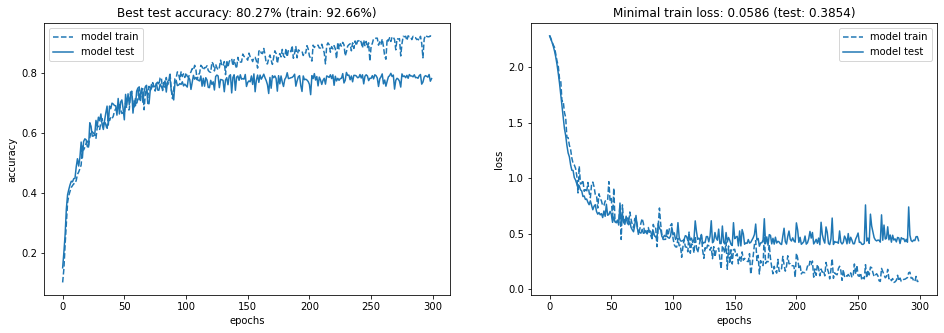

In [4]:
model = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
history = trainer.train(model, optimizer, n_epochs=n_epochs)
show_results(model=history)

If the above was defined correctly, you can see that after ~$50$ epochs (if you used the same hyperparameters as suggested above) the test loss starts rising and the test accuracy flattens out. This means that our model has started *overfitting* to the training set. If we want to get the best model out of this architecture, we would need to load in the parameters from the moment when the test accuracy was highest (so-called *early stopping*, perhaps the most popular regularization technique in deep learning). Your task today will be to improve upon these results.

## Parameter Norm Penalties
A simple way of doing non-architecture-dependent regularization is by adding a penalty $\Omega(\theta)$ to the loss function $J(\theta)$:

$$\tilde{J}(\theta) = J(\theta) + \alpha \Omega(\theta),$$

where $\alpha \in [0, \infty)$ is a hyperparameter that weights the contribution of the penalty term $\Omega$.

When using such regularization for neural networks, we typically penalize only the weights and not the biases -- we do not introduce too much variance by leaving them unregularized and doing so can introduce significant underfitting.

$L_1$ and $L_2$ regularization, which you might know from regular machine learning, fall into this family of methods. We will not be talking about them today, but move to methods specific to neural networks.

## Task 2 (0.75p): Dropout
Dropout is regularization method where during training some number of outputs are randomly ignored (or *dropped out*). This prevents complex co-adaptations from arising (e.g. one neuron learning to fix the mistakes of another), which makes the model more robust.

![dropout](figures/dropout.png)
<center>Source: <a href="https://jmlr.org/papers/v15/srivastava14a.html">Dropout: A Simple Way to Prevent Neural Networks from Overfitting</a>.</center>

Dropout is not used after testing, but we need to correct for the fact that the network is used to smaller outputs, hence we need to scale the output by the chosen dropout rate.

In [5]:
class Dropout(torch.nn.Module):
    
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p
        
    def forward(self, x):
        if self.training:
            # hint: use torch.bernoulli
            mask = torch.bernoulli(self.p * torch.ones_like(x)).long()
            out = x.clone()
            out[mask == 1] = 0.
            return out
        else:
            return (1-self.p) * x

In [6]:
test_dropout(Dropout)

Add dropout with probability $0.5$ to the baseline model after each hidden layer.

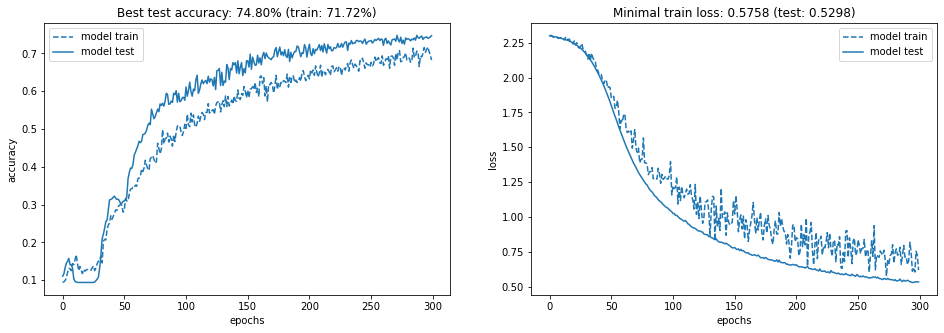

In [7]:
model = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    Dropout(0.5),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    Dropout(0.5),
    torch.nn.Linear(256, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
dropout_history = trainer.train(model, optimizer, n_epochs=n_epochs)
show_results(model=dropout_history)

### Questions:
1. How does the testing accuracy curve after applying dropout look in comparison to the baseline model? What does that suggest? 
2. How can we think of dropout as ensemble learning (combining many models at once)?

[your answers here]

## Task 3 (1p): Batch Normalization

Batch Normalization was introduced as a technique to reduce *internal covariate shift*. To understand this perspective, recall that training a neural network can be viewed as solving a collection of separate optimization problems -- one for each layer:

![layer based](figures/layerbased.jpg)
<center>Source: <a href="https://gradientscience.org/batchnorm/">How does Batch Normalization Help Optimization?</a></center>

During training, each step involves updating the parameters for all layers simultaneously. This implies that updates to the earlier layers change the input distribution of later layers, hence the optimization problems change at each step (this is the aforementioned internal covariate shift). To fix that, we whiten the input, so the input distribution is the same:

$$\hat{\mathbf{x}_i} = \frac{\mathbf{x}_i - \mathbf{\mu_B}}{\sqrt{\mathbf{\sigma^2_B} + \epsilon}},$$

where $\mathbf{\mu_B}=\frac{1}{m}\sum_{i=1}^m \mathbf{x}_i$ and $\mathbf{\sigma^2_B}  = \frac{1}{m} \sum_{i=1}^m (\mathbf{x}_i - \mathbf{\mu_B)^2}$ are the batch mean and batch variance respectively (ideally we'd want to do this over the whole training set, but in the context of stochastic gradient methods that would be impractical) and $\epsilon$ is added for numerical stability. To restore the representational power of the network, we modify $\hat{\mathbf{x}_i}$ with learned parameters $\gamma$ and $\beta$, so any mean and variance can be learned. In the end, the batch norm layer looks like this:

$$\mathtt{BN}(\mathbf{x}_i) = \gamma \hat{\mathbf{x}_i} + \beta.$$

During testing, we replace the batch statistics with population statistics computed during training via running means:

$$\mathbf{\overline{\mu}_{new}} =  (1 - \lambda) \mathbf{\overline{\mu}_{old}} + \lambda \mathbf{\mu_B},$$

$$\mathbf{\overline{\sigma}_{new}} = (1 - \lambda) \mathbf{\overline{\sigma}_{old}} + \lambda \mathbf{\sigma_B},$$

where $\lambda$ is the momentum term for the running means.

While the effectiveness of batch normalization is hard to dispute, the proposed mechanism is contested. See [How does Batch Normalization Help Optimization?](https://gradientscience.org/batchnorm/) for more on this topic.

When defining model parameters it can be useful to utilize [`torch.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html). When defining non-trainable parameters (e.g. running means) use [`torch.nn.Module.register_buffer`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) instead.

In [8]:
class BatchNorm(torch.nn.Module):
    
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm, self).__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        
        self.register_buffer('mu', torch.zeros(num_features))
        self.register_buffer('sigma', torch.ones(num_features))
        
        self.gamma = torch.nn.Parameter(torch.ones(num_features))
        self.beta =  torch.nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        if self.training:
            batch_mu = x.mean(dim=0)
            batch_sigma = x.var(dim=0)
            
            x_hat = (x - batch_mu) / torch.sqrt(batch_sigma + self.eps)
            
            self.mu = (1 - self.momentum) * self.mu + self.momentum * batch_mu
            self.sigma = (1 - self.momentum) * self.sigma + self.momentum * batch_sigma
            
        else:
            x_hat = (x - self.mu) / torch.sqrt(self.sigma + self.eps)
            
        return self.gamma * x_hat + self.beta
        

In [9]:
test_bn(BatchNorm)

Add batch normalization to the baseline model after each hidden layer.

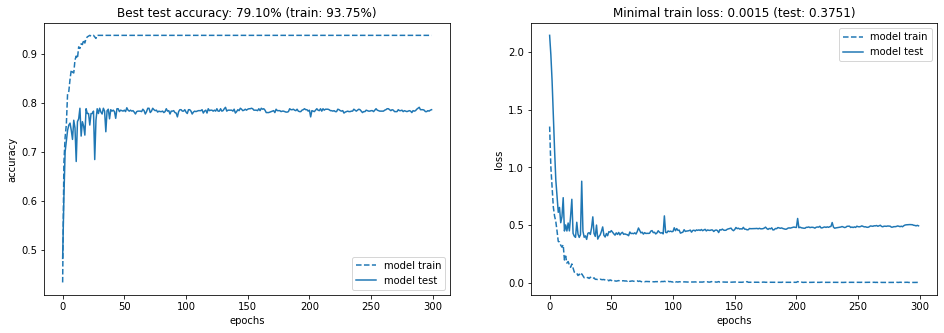

In [10]:
model = torch.nn.Sequential(
    torch.nn.Linear(784, 256), 
    BatchNorm(256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    BatchNorm(256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
bn_history = trainer.train(model, optimizer, n_epochs=n_epochs)
show_results(model=bn_history)

### Questions:
1. Should batch normalization be used before or after the activation function? Why? (Hint: not sure there is a good answer.)
2. Can we think of batch normalization as regularization? Why? 

[your answers here]

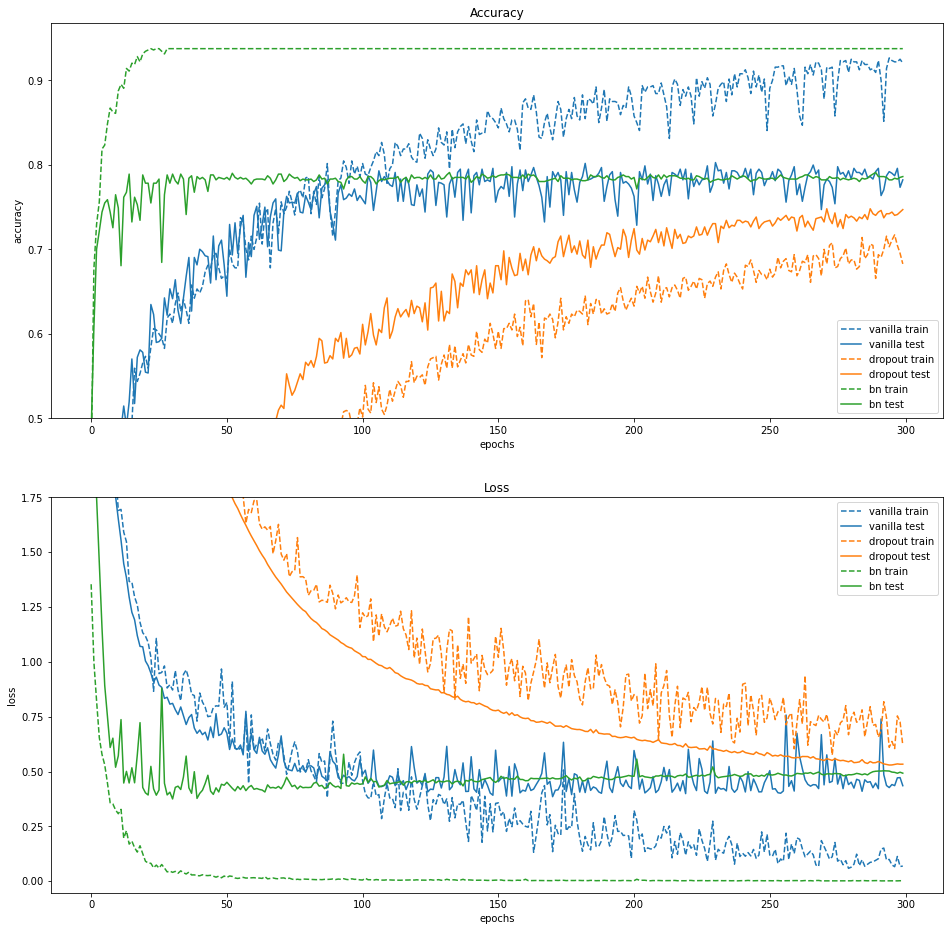

In [11]:
show_results(vanilla=history, dropout=dropout_history, bn=bn_history, 
             orientation='vertical', accuracy_bottom=0.5, loss_top=1.75)